# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [1]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [2]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  


#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


**1.2:**  How will your solution be used?


**1.3:**  How should success (or failure) be measured?


___

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

#### **Preliminary Data Analysis**

In [3]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

#### **Preliminary Data Analysis: Null Feature Counts**

In [5]:
def show_null_counts_features(df):
    import numpy as np
    import pandas as pd
    
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)
    
    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')
    
    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        'Null Values': count_nulls[count_nulls > 0].values,  # match print statement
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)
    
    print(f'The dataset contains {len(df)} samples.\n')
    
    if len(missing_data) == 0:
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print(f"{'Feature':<30} {'Null Values':>12} {'Null %':>10} {'Type':>10}")
        print("-" * 70)
        for _, row in missing_data.iterrows():
            print(
                f"{row['Feature']:<30} "
                f"{row['Null Values']:>12} "
                f"{row['Null %']:>10} "
                f"{row['Type']:>10}"
            )

In [6]:
show_null_counts_features(df)

The dataset contains 77613 samples.

Feature                         Null Values     Null %       Type
----------------------------------------------------------------------
buildingclasstypeid                   77598      99.98    Numeric
finishedsquarefeet13                  77571      99.95    Numeric
basementsqft                          77563      99.94    Numeric
storytypeid                           77563      99.94    Numeric
yardbuildingsqft26                    77543      99.91    Numeric
fireplaceflag                         77441      99.78 Categorical
architecturalstyletypeid              77406      99.73    Numeric
typeconstructiontypeid                77390      99.71    Numeric
finishedsquarefeet6                   77227       99.5    Numeric
pooltypeid10                          77148       99.4    Numeric
decktypeid                            76999      99.21    Numeric
poolsizesum                           76744      98.88    Numeric
pooltypeid2                      

In [7]:
df_numeric = df.select_dtypes(include=['number'])
df_categorical = df.select_dtypes(exclude=['number'])

In [8]:
df_categorical['fireplaceflag'].unique()

array([nan, True], dtype=object)

In [9]:
# Summarize the datasets using describe()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
parcelid,77613.0,1.300781e+07,3.518717e+06,1.071186e+07,1.153821e+07,1.253004e+07,1.421101e+07,1.676893e+08
airconditioningtypeid,25007.0,1.812013e+00,2.965768e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,207.0,7.386473e+00,2.728030e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03
bathroomcnt,77579.0,2.298496e+00,9.967317e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,77579.0,3.053223e+00,1.140480e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
buildingqualitytypeid,49809.0,6.533779e+00,1.722062e+00,1.000000e+00,6.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,76963.0,2.316392e+00,9.796893e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
decktypeid,614.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01


In [10]:
print(f"This dataset contain {df.shape[0]} rows")
print(f"This dataset contain {df.shape[1]} columns")

# basic aggregates
data_profiling = df.agg(['count', 'nunique']).transpose()
data_profiling

This dataset contain 77613 rows
This dataset contain 55 columns


,count,nunique
parcelid,77613,77414
airconditioningtypeid,25007,5
architecturalstyletypeid,207,5
basementsqft,50,43
bathroomcnt,77579,22
bedroomcnt,77579,16
buildingclasstypeid,15,2
buildingqualitytypeid,49809,12
calculatedbathnbr,76963,21
decktypeid,614,1


In [11]:
data_profiling_unique_columns = data_profiling[data_profiling['count'] == data_profiling['nunique']]
print(data_profiling_unique_columns)

Empty DataFrame
Columns: [count, nunique]
Index: []


In [17]:
number_of_duplicates = df['parcelid'].duplicated().sum()

# show duplicated if any:
if  number_of_duplicates > 0:
    print(f"Number of duplicated Rows: {number_of_duplicates:,d}")    
else:
    print("No duplicates found.")
df_duplicates = df[df['parcelid'].duplicated()]

df_duplicates.head()

Number of duplicated Rows: 199


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
117,11393337,NaN,NaN,NaN,3.0,3.0,NaN,4.0,3.0,NaN,...,NaN,NaN,1940.0,NaN,NaN,2016.0,Y,14.0,6.037235e+13,43439.0
625,14634203,1.0,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1974.0,1.0,NaN,2016.0,NaN,NaN,6.059001e+13,289445.0
1018,11721753,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,NaN,...,NaN,NaN,1923.0,NaN,NaN,2016.0,NaN,NaN,6.037220e+13,205123.0
1248,11289917,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,Y,15.0,6.037901e+13,136104.0
1734,11637029,1.0,NaN,NaN,2.0,3.0,NaN,9.0,2.0,NaN,...,NaN,NaN,1980.0,NaN,NaN,2016.0,Y,13.0,6.037701e+13,810694.0


In [13]:
df_unique = df.drop_duplicates(subset=['parcelid'], keep='last')
df_unique.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


#### **2.A Discussion:** Answer the following questions.

**2.A.1:  Which features are categorical?**

The following features are categorical: 
- **hashottuborspa**
    - boolean -- either nan or True
    - 98.02 % null

- **propertycountylandusecode**
    - 75 distinct property codes
    - 0.04% null

- **propertyzoningdesc**
    - 1907 distinct property zoning descriptions
    - 34.96 % null

- **fireplaceflag**
    - boolean -- either nan or True
    - 99.78% null

- **taxdelinquencyflag**
    - boolean -- either nan or Y
    - 96.26% null

**2.A.2:  Are there any features which appear at first glance to be *useless* for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly.**


Yes -- first of all, there are a large number of `ID` columns that are present in our dataset. At this time, we don't have the necessary information to discern what **airconditioningtypeid** or **architecturalstyletypeid** mean in useful terms for the purpose of this analysis -- therefore these columns should be dropped -- especially if they contain a large number of null values as well.

Features **latitude** and **longitude** provide the property's geographic coordinates, which could be geocoded to extract location-based insights, although this process is beyond the scope of the current milestone.

The **propertyzoningdesc** feature provides a description of the property's zoning, but with 1908 unique text codes of uncertain meaning, it is not viable for use in the current milestone without significant preprocessing or grouping.


**2.A.3: Are there any features which appear to be *useless* because of the percentage of missing values?  If so, give an example.**

The following features appear to be uninformative due to the high percentage of missing values. In general, any non-boolean feature with over 60% null values was considered unsuitable for future analysis and will be dropped.

Additionally, a few boolean features (formatted as either True/T or null) were also excluded. While this format is not inherently problematic, each of these features had over 95% null values. With such a high proportion of missing data, it is unclear whether the lack of values is inherent to the variable itself or the result of inconsistent data entry, making them unreliable for analysis.

The boolean-type features excluded for this reason are:

-  fireplaceflag
- hashottuborspa
- taxdelinquencyflag

In summary, the following features will be dropped due to high null percentages and/or data quality concerns:
 

| Feature                      | Null Values | Null % | Type         |
|-----------------------------|-------------|--------|--------------|
| buildingclasstypeid         | 77,598      | 99.98% | Numeric      |
| finishedsquarefeet13        | 77,571      | 99.95% | Numeric      |
| basementsqft                | 77,563      | 99.94% | Numeric      |
| storytypeid                 | 77,563      | 99.94% | Numeric      |
| yardbuildingsqft26          | 77,543      | 99.91% | Numeric      |
| fireplaceflag               | 77,441      | 99.78% | Categorical  |
| architecturalstyletypeid    | 77,406      | 99.73% | Numeric      |
| typeconstructiontypeid      | 77,390      | 99.71% | Numeric      |
| finishedsquarefeet6         | 77,227      | 99.50% | Numeric      |
| pooltypeid10                | 77,148      | 99.40% | Numeric      |
| decktypeid                  | 76,999      | 99.21% | Numeric      |
| poolsizesum                 | 76,744      | 98.88% | Numeric      |
| pooltypeid2                 | 76,539      | 98.62% | Numeric      |
| hashottuborspa              | 76,074      | 98.02% | Categorical  |
| yardbuildingsqft17          | 75,220      | 96.92% | Numeric      |
| taxdelinquencyflag          | 74,713      | 96.26% | Categorical  |
| taxdelinquencyyear          | 74,713      | 96.26% | Numeric      |
| finishedsquarefeet15        | 74,586      | 96.10% | Numeric      |
| finishedsquarefeet50        | 71,576      | 92.22% | Numeric      |
| finishedfloor1squarefeet    | 71,576      | 92.22% | Numeric      |
| fireplacecnt                | 69,324      | 89.32% | Numeric      |
| threequarterbathnbr         | 67,507      | 86.98% | Numeric      |
| pooltypeid7                 | 62,534      | 80.57% | Numeric      |
| poolcnt                     | 61,439      | 79.16% | Numeric      |
| numberofstories             | 60,014      | 77.32% | Numeric      |
| airconditioningtypeid       | 52,606      | 67.78% | Numeric      |
| garagecarcnt                | 52,093      | 67.12% | Numeric      |
| garagetotalsqft             | 52,093      | 67.12% | Numeric      |
| regionidneighborhood        | 46,639      | 60.09% | Numeric      |


#### **Comment / Hypothesis:**
Instead of dropping columns like **fireplaceflag** or other high-null integer/boolean features above, **we can hypothesize that missing values often represent a valid “no” or “zero” state.**

For example, if **fireplaceflag** is null, we can assume it means “no fireplace” and set it to 0 (False). Similarly, for numeric columns like **basementsqft**, a missing value could be treated as 0 to indicate there is no basement. 

We can also create additional indicator columns (e.g., has_fireplace = 1 if not null, otherwise 0) to capture any information in the missingness itself. 

By applying these transformations, we can retain potentially useful features and then empirically evaluate whether they improve our models rather than discarding them outright.

**2.A.4: Are there any features which appear to be *useless* because of the number of unique values?  If so, give an example.**

The following feature variables can probably be droped due to lack of variables: 

 - **assessmentyear** Assessment Year. Only one value, 2016
 - **buildingclasstypeid**: Identifier for the building framing type. 2 unique values and just 15 rows populated. 
 - **storytypeid**: Identifier for the type of stories in the building. 1 identifier in 350 rows.

Variables with too many unique values:
 - **parcelid**: Unique identifier for the property parcel. Primary key, does not have any value for ML.
 - **rawcensustractandblock**: Unprocessed census tract and block identifier. ~39k unique IDs 
 - **censustractandblock**: A combined identifier for the property’s census tract and block group.  ~39k unique IDs 
 - **latitude**: Latitude coordinate of the property.  Out of scope
 - **longitude**: Longitude coordinate of the property.   Out of scope
 - **propertyzoningdesc**: Description of the property's zoning. Descriptive info with 1908 unique text codes.
 - **regionidneighborhood**: Identifier for the neighborhood. 480 ids
 - **regionidzip**: Identifier for the ZIP code.  389 ids. Grouping to states/zones can be implemented. 
 - **regionidcity**: Identifier for the city.  175 city ids. Encoding is manageable but not as part of this milestone.
 - **yearbuilt**: Year the property was built.  136 years. Grouping to decades, plus creating a new feature **propertyage** = **yearbuilt** - **assessmentyear**
 - **propertycountylandusecode**: County land use code for the property. 75 unknown ids. 


Target: 
 - **taxvaluedollarcnt**: Total assessed value of the property in dollars.  

Additionally, most columns containing 'id' in their names can be dropped, as they typically represent either unique identifiers or encoded categorical types that are not interpretable without access to supplementary datasets. For example, a value of 56784 in a column like airconditioningtypeid holds no meaningful distinction from a value like 30495 without a corresponding lookup table.

Without access to such reference data, we cannot interpret these fields in a way that adds value to our analysis. Moreover, these ID fields are often treated as ordinal categorical variables, despite representing unordered categories (e.g., types of air conditioning). Including them in the modeling process could introduce noise or lead to misleading conclusions, so they should be removed from the dataset.

Upon further inspection, there are some additional feature variables that require further inspection before the determination can be made to keep them in the dataset or remove them before moving forward. Variables like yardbuildingsqft17 vs yardbuildingsqft26 should be evaluated further to see if they offer any meaningful information (distinct from each other) towards this analysis. 


#### **Comment / Hypothesis:**
While it's often advised to drop ID fields due to interpretability issues without a lookup table, not all such features should be discarded outright. For instance, **airconditioningtypeid** has only 5 unique values and is populated in 25k rows. 

This suggests that it likely encodes a small set of meaningful categories (e.g., different types of air conditioning), and missing values could be interpreted as "no air conditioning." Instead of dropping it, we can encode this feature as a categorical variable (using one-hot encoding or similar techniques) and validate its contribution to the model. This approach preserves potentially useful information and enables us to test whether the feature adds value to our analysis.

Specifically, for example, we can encode the **airconditioningtypeid** feature into 5 distinct categories representing different types of air conditioning, and also create an additional indicator variable, such as **airconditioning_exists**, which flags whether the property has any air conditioning (i.e., non-missing value) or not (missing value).

___

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

<Figure size 1600x4000 with 0 Axes>

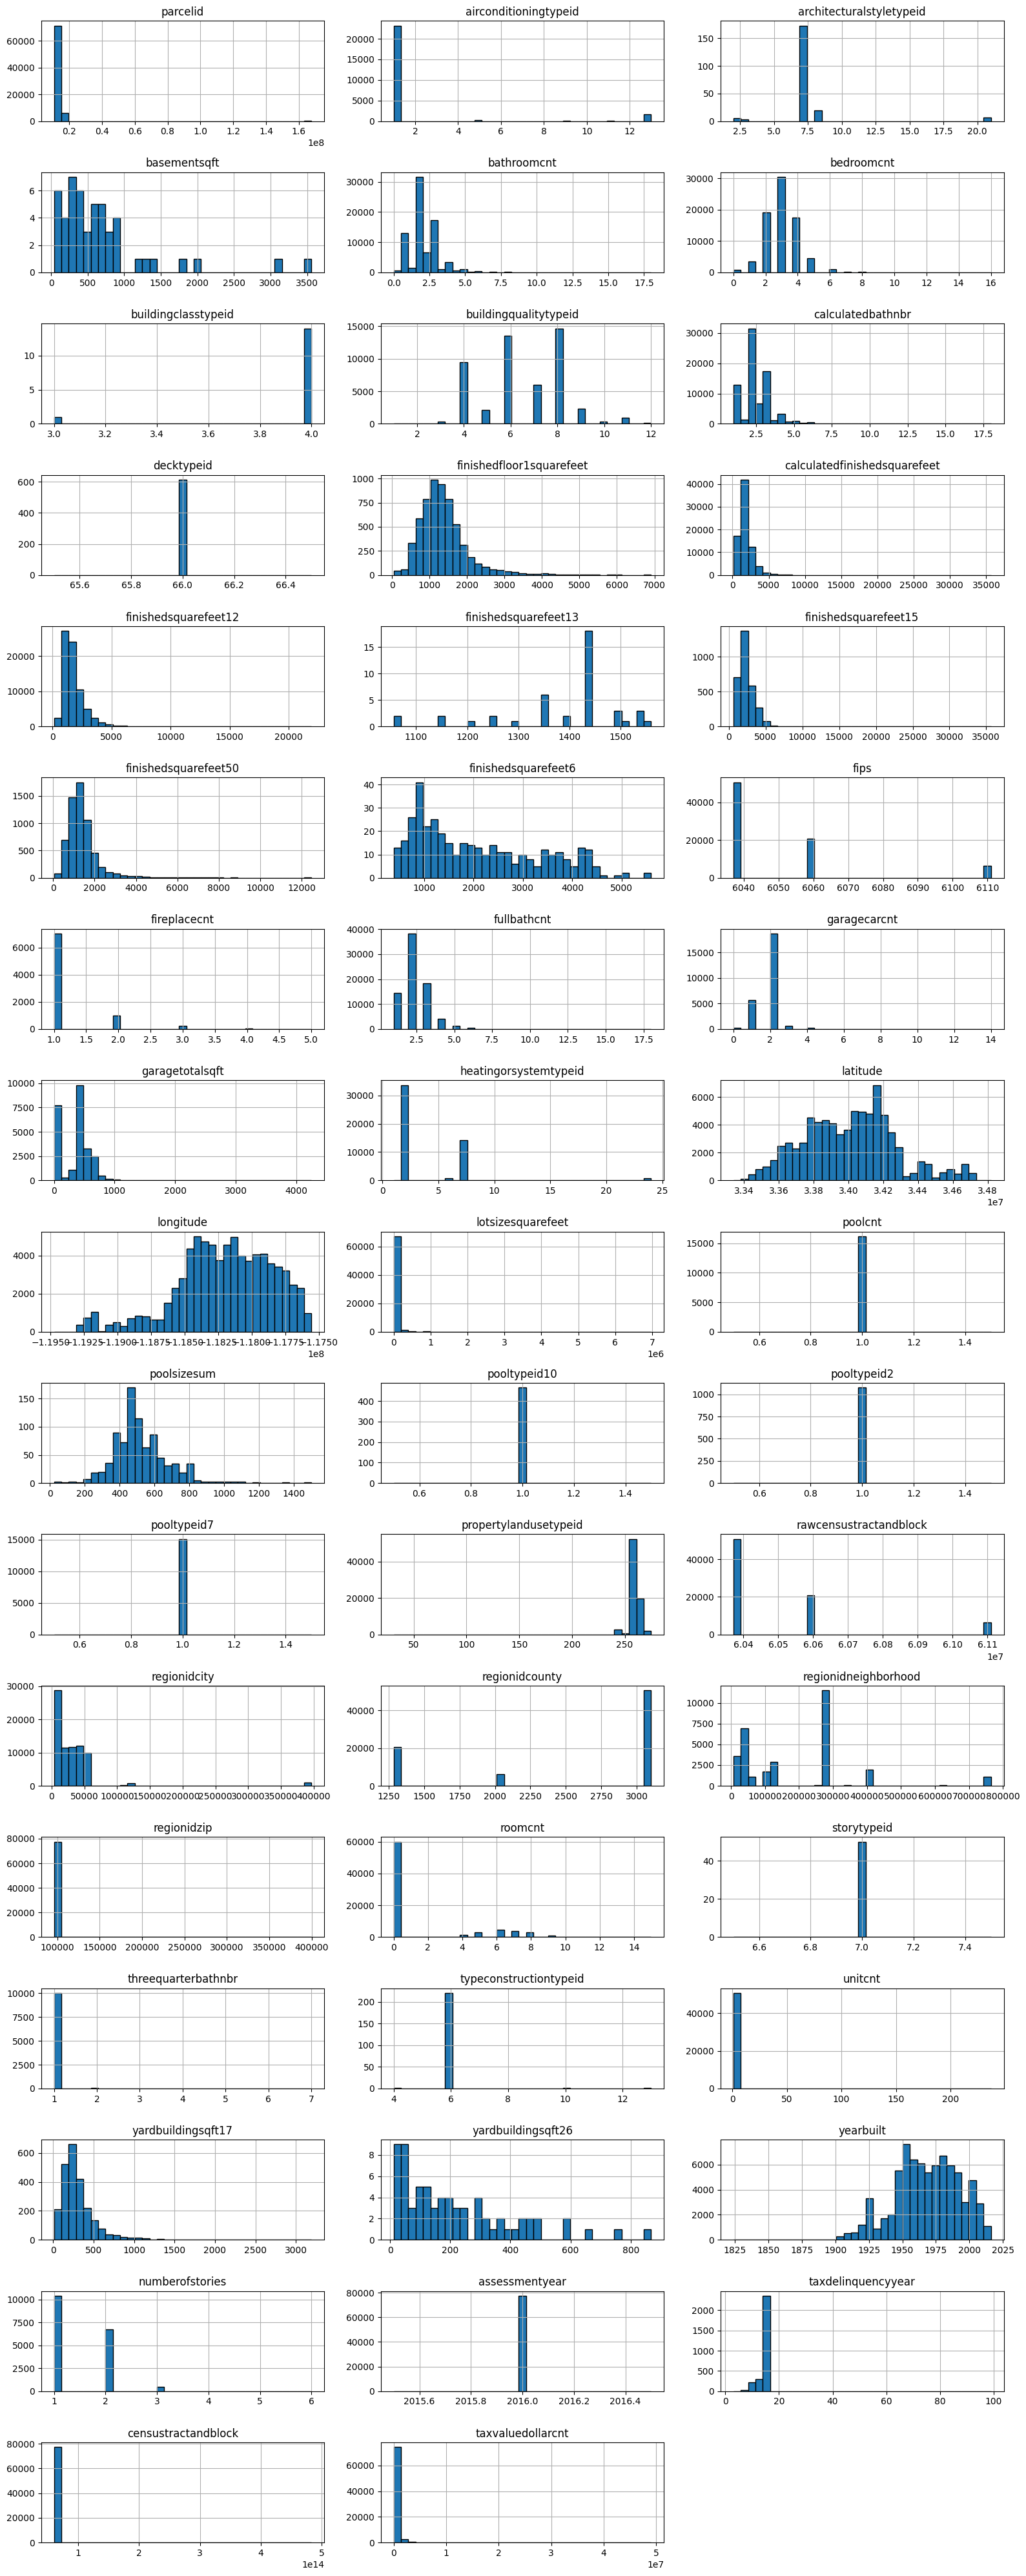

In [14]:
plt.figure(figsize=(16,40))
df_numeric.hist(bins=35, figsize=(16, 40), layout=(-1,3), edgecolor='black')
plt.tight_layout()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [ ]:
#######################################
# Drop and create some new features: 
#######################################
# Create a copy of the original DataFrame
df_clean = df.copy()

# Create new features based on yearbuilt:
# Compute property age using 2016 as the assessment year
df_clean['propertyage'] = 2016 - df_clean['yearbuilt']

# Optionally, group yearbuilt by decade (e.g., 1900s, 1910s, etc.)
df_clean['yearbuilt_decade'] = (df_clean['yearbuilt'] // 10) * 10

# List of columns to drop:
columns_to_drop = [
    "architecturalstyletypeid", # 5 unique values, very few rows populated (208)
    "assessmentyear",           # Only one value, 2016
    "buildingclasstypeid",      # 2 unique values, very few rows populated
    "storytypeid",              # 1 unique value in 350 rows
    "parcelid",                 # Unique identifier; not useful for ML
    "rawcensustractandblock",   # Unprocessed census tract and block; ~39k unique IDs
    "censustractandblock",      # Processed census tract and block; ~39k unique IDs
    "latitude",                 # Out of scope
    "longitude",                # Out of scope
    "propertyzoningdesc",       # 1908 unique text codes with unknown meaning
    "regionidneighborhood",     # 480 unique values
    "regionidzip",              # 389 unique values (could be grouped, but not for this milestone)
    "regionidcity",             # 175 unique values (encoding manageable, but not part of this milestone)
    "yearbuilt",                # Already used to compute propertyage and yearbuilt_decade
    "propertycountylandusecode" # 75 unknown IDs
]

# Drop the listed columns from the copy
df_clean = df_clean.drop(columns=columns_to_drop)

# Check the updated DataFrame structure
df_clean.head()


,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,...,unitcnt,yardbuildingsqft17,yardbuildingsqft26,numberofstories,fireplaceflag,taxdelinquencyflag,taxdelinquencyyear,taxvaluedollarcnt,propertyage,yearbuilt_decade
0,NaN,NaN,3.5,4.0,NaN,3.5,NaN,NaN,3100.0,3100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023282.0,18.0,1990.0
1,NaN,NaN,1.0,2.0,NaN,1.0,NaN,1465.0,1465.0,1465.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,464000.0,49.0,1960.0
2,NaN,NaN,2.0,3.0,NaN,2.0,NaN,NaN,1243.0,1243.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,564778.0,54.0,1960.0
3,NaN,NaN,3.0,4.0,8.0,3.0,NaN,NaN,2376.0,2376.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,145143.0,46.0,1970.0
4,1.0,NaN,3.0,3.0,8.0,3.0,NaN,NaN,1312.0,1312.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,119407.0,52.0,1960.0


In [ ]:
#######################################
# Impute missing values
#######################################

In [ ]:
#######################################
# Encode categorical features
#######################################

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

